# Astronomical Coordinates 3: Working with Velocity Data in astropy.coordinates

## Authors
Adrian Price-Whelan

## Learning Goals
* Introduce how to represent and transform velocity data in `SkyCoord` objects
* Demonstrate how to predict the position of a star at a time using its proper motion

## Keywords
coordinates


## Summary

In the previous tutorial in this series, we showed how astronomical *positional* coordinates can be represented and transformed in Python using the `SkyCoord` object ([docs](https://docs.astropy.org/en/stable/coordinates/skycoord.html)). Many sources, especially stars (thanks to the Gaia mission), have measured velocities or measured components of their velocity (e.g., just proper motion, or just radial velocity).

In this tutorial, we will explore how the `astropy.coordinates` package can be used to represent and transform astronomical coordinates that have associated velocity data. You may find it helpful to keep [the Astropy documentation for the coordinates package](http://docs.astropy.org/en/stable/coordinates/index.html) open alongside this tutorial for reference or additional reading. In the text below, you may also see some links that look like ([docs](http://docs.astropy.org/en/stable/coordinates/index.html)). These links will take you to parts of the documentation that are directly relevant to the cells from which they link. 

*Note: This is the 3rd tutorial in a series of tutorials about astropy.coordinates. If you are new to astropy.coordinates, you may want to start from the beginning or an earlier tutorial.*
- [Previous tutorial: Astronomical Coordinates 2 - Transforming Coordinate Systems and Representations¶](2-Coordinates-Transforms)
- [Next tutorial: Astronomical Coordinates 4 - Cross-matching Catalogs](4-Coordinates-Crossmatch)

## Imports

We start by importing some general packages we will need below:

In [23]:
import warnings

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance, Galactic
import astropy.coordinates as coord
from astropy.io import fits
from astropy.table import QTable
from astropy.time import Time
from astropy.utils.data import download_file
from astropy.wcs import WCS

from astroquery.gaia import Gaia

## More Than Sky Positions: Including Velocity Data in `SkyCoord`

As we have seen in the previous tutorials, the `SkyCoord` object can be used to store scalars or arrays of positional coordinate information and supports transforming between different coordinate frames and representations. But  `astropy.coordinates` also supports representing and transforming *velocity* information along with positions ([docs](http://docs.astropy.org/en/latest/coordinates/velocities.html)).

## Passing Velocity Data into `SkyCoord`

Velocity components are passed in to `SkyCoord` in the same way that positional components are specified: As arguments to the `SkyCoord` class. For example, to create a `SkyCoord` to represent a sky position and a proper motion in the (default) ICRS coordinate frame, in addition to the position components `ra`, `dec`, we can pass in values for the proper motion components `pm_ra_cosdec`, `pm_dec` ("pm" for "proper motion"):

In [2]:
SkyCoord(
    ra=10*u.deg, 
    dec=20*u.deg,
    pm_ra_cosdec=1*u.mas/u.yr,
    pm_dec=2*u.mas/u.yr)

<SkyCoord (ICRS): (ra, dec) in deg
    (10., 20.)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (1., 2.)>

Like the examples in previous tutorials demonstrated for positional coordinates, we can also create an array-valued `SkyCoord` object by passing in arrays of data for all of the components:

In [3]:
SkyCoord(
    ra=np.linspace(0, 10, 5)*u.deg, 
    dec=np.linspace(5, 20, 5)*u.deg,
    pm_ra_cosdec=np.linspace(-5, 5, 5)*u.mas/u.yr,
    pm_dec=np.linspace(-5, 5, 5)*u.mas/u.yr)

<SkyCoord (ICRS): (ra, dec) in deg
    [( 0. ,  5.  ), ( 2.5,  8.75), ( 5. , 12.5 ), ( 7.5, 16.25),
     (10. , 20.  )]
 (pm_ra_cosdec, pm_dec) in mas / yr
    [(-5. , -5. ), (-2.5, -2.5), ( 0. ,  0. ), ( 2.5,  2.5), ( 5. ,  5. )]>

However, for some of the examples below we will continue to use scalar values for brevity. 

You can also specify radial velocity data with the `radial_velocity` argument:

In [4]:
velocity_coord = SkyCoord(
    ra=10*u.deg, 
    dec=20*u.deg,
    pm_ra_cosdec=1*u.mas/u.yr,
    pm_dec=2*u.mas/u.yr,
    radial_velocity=100*u.km/u.s)
velocity_coord

<SkyCoord (ICRS): (ra, dec) in deg
    (10., 20.)
 (pm_ra_cosdec, pm_dec, radial_velocity) in (mas / yr, mas / yr, km / s)
    (1., 2., 100.)>

The component data can then be accessed using the same names used to pass in the velocity components:

In [5]:
velocity_coord.pm_ra_cosdec

<Quantity 1. mas / yr>

In [6]:
velocity_coord.radial_velocity

<Quantity 100. km / s>

A `SkyCoord` object with velocity data can be transformed to other frames just like the position-only coordinate objects we used in the previous tutorials:

In [7]:
velocity_coord_gal = velocity_coord.transform_to(Galactic())
velocity_coord_gal

<SkyCoord (Galactic): (l, b) in deg
    (119.26936774, -42.79039286)
 (pm_l_cosb, pm_b, radial_velocity) in (mas / yr, mas / yr, km / s)
    (1.11917063, 1.93583499, 100.)>

Note that, like the position components, which change from `ra`,`dec` to `l`,`b`, the proper motion component names have changed to reflect naming conventions for the component names in a given frame: `pm_ra_cosdec` and `pm_dec` have become `pm_l_cosb` and `pm_b`:

In [8]:
velocity_coord_gal.pm_l_cosb

<Quantity 1.11917063 mas / yr>

In [9]:
velocity_coord_gal.pm_b

<Quantity 1.93583499 mas / yr>

An important caveat to note when transforming a `SkyCoord` object with velocity data is that some reference frames require knowing the distances, or the full velocity vectors (i.e. proper motion components and radial velocity) in order to transform the velocities correctly. For example, a `SkyCoord` with only sky position and proper motion data cannot be transformed to a frame with a positional or velocity offset, such as the `Galactocentric` frame ([docs](https://docs.astropy.org/en/stable/coordinates/galactocentric.html))

In [10]:
test_coord = SkyCoord(
    ra=10*u.deg, 
    dec=20*u.deg,
    pm_ra_cosdec=1*u.mas/u.yr,
    pm_dec=2*u.mas/u.yr)

# This cell will raise an exception - this is expected!
test_coord.transform_to(coord.Galactocentric())

ConvertError: Transforming to/from a Galactocentric frame requires a 3D coordinate, e.g. (angle, angle, distance) or (x, y, z).

## Evolving Coordinate Positions Between Epochs

For nearby or fast-moving stars, a star's position could change appreciably between two well-spaced observations of the source. For such cases, it might be necessary to compute the position of the star at a given time using the proper motion or velocity of the star. Let's demonstrate this idea by comparing the sky position of a source as measured by [*Gaia* Data Release 2](https://www.cosmos.esa.int/web/gaia/dr2) (given at the epoch J2015.5) to an image near this source from the Digitized Sky Survey (DSS; digital scans of photographic plates observed in the 1950s). 

From previous astrometric measurements, we know that the star HD 219829 has very large proper motion: Close to 0.5 arcsec/year! Between the DSS and *Gaia*, we therefore expect that the position of the star has changed by about 0.5 arcmin. Let's see if this is the case! 

To start, we will query the *Gaia* catalog to retrieve data for this star (skip the cell below if you do not have an internet connection - we have provided the table locally as well). We use a large search radius so many sources will be returned

In [11]:
# Skip this cell if you are not connected to the internet
gaia_tbl = Gaia.query_object(SkyCoord.from_name('HD 219829'), 
                             radius=1*u.arcmin)

In [12]:
# the .read() below produces some warnings that we can safely ignore
with warnings.catch_warnings(): 
    warnings.simplefilter('ignore', UserWarning)
    
    gaia_tbl = QTable.read('HD_219829_query_results.ecsv')

We know that HD 219829 will be the brightest source in this small region, so we can extract the row with the smallest G-band magnitude. Let's check the proper motion values for this source to make sure that they are large:

In [15]:
hd219829_row = gaia_tbl[gaia_tbl['phot_g_mean_mag'].argmin()]
hd219829_row['source_id', 'pmra', 'pmdec']

source_id,pmra,pmdec
,mas / yr,mas / yr
int64,float64,float64
2661015540210781568,483.4165901889734,-114.8633971841528


Indeed, it looks like this is our source! Let's construct a `SkyCoord` object for this source using the data from the *Gaia* archive:

*Note about the Gaia catalog proper motion column names: The names in the Gaia archive and other repositories containing Gaia data give Right Ascension proper motion values simply as "pmra". These components implicitly contain the `cos(dec)` term, so we do **not** have to modify these values in order to pass them in to `SkyCoord` as `pm_ra_cosdec`*

In [20]:
hd219829_coord = SkyCoord(
    ra=hd219829_row['ra'], 
    dec=hd219829_row['dec'],
    distance=Distance(parallax=hd219829_row['parallax']),
    pm_ra_cosdec=hd219829_row['pmra'],
    pm_dec=hd219829_row['pmdec'],
    obstime=Time(hd219829_row['ref_epoch'], format='jyear'))

hd219829_coord

<SkyCoord (ICRS): (ra, dec, distance) in (deg, deg, pc)
    (349.72896716, 5.40511585, 34.47896069)
 (pm_ra_cosdec, pm_dec) in mas / yr
    (483.41659019, -114.86339718)>

We now have a `SkyCoord` representation of the position and proper motion of the star HD 219829 as measured by *Gaia* and reported at the epoch J2015.5. What does this mean exactly? *Gaia* actually measures the (time-dependent) position of a star every time it scans the part of the sky that contains the source, and this is how *Gaia* is able to measure proper motions of stars. However, if every star is moving and changing its sky positions, how do we ever talk about "the sky position" of a star as opposed to "the sky trajectory of a star"?! The key is that catalogs often only report the position of a source at some reference epoch. For a survey that only observes the sky once or a few times (e.g., SDSS or 2MASS), this reference epoch might be "the time that the star was observed." But for a mission like *Gaia*, which scans the sky many times, they perform astrometric fits to the individual position measurements, which allow them to measure the parallax, proper motion, and the reference position at a reference time for each source. For *Gaia* data release 2, the reference time is J2015.5, and the sky positions (and other quantities) reported in the catalog for each source are at this epoch. 

In `SkyCoord`, we specify the "epoch" of an observation using the `obstime` argument, as we did above. Now that we have a coordinate object for HD 219829, let's now compare the position of the star as measured by *Gaia* to its apparent position in an image from the DSS. Let's now query the DSS to retrieve a FITS image of the field around this star, using the STSCI DSS image cutout service. Skip the cell below if you do not have an internet connection (we have provided the image locally as well):

In [24]:
# Skip this cell if you are not connected to the internet
dss_cutout_filename = download_file(
    f"http://archive.stsci.edu/cgi-bin/dss_search?"
    f"f=FITS&ra={hd219829_coord.ra.degree}&dec={hd219829_coord.dec.degree}"
    f"&width=4&height=4")  # width/height in arcmin

In [22]:
dss_cutout_filename = 'dss_hd219829.fits'

We can now load the FITS image of the cutout and use `astropy.visualization` to display the image using its World Coordinate System (WCS) info ([docs](http://docs.astropy.org/en/latest/visualization/wcsaxes/index.html)). By passing in the WCS information (included in the FITS cutout header), we can over-plot a marker for the *Gaia*-measured sky position of HD 219829:

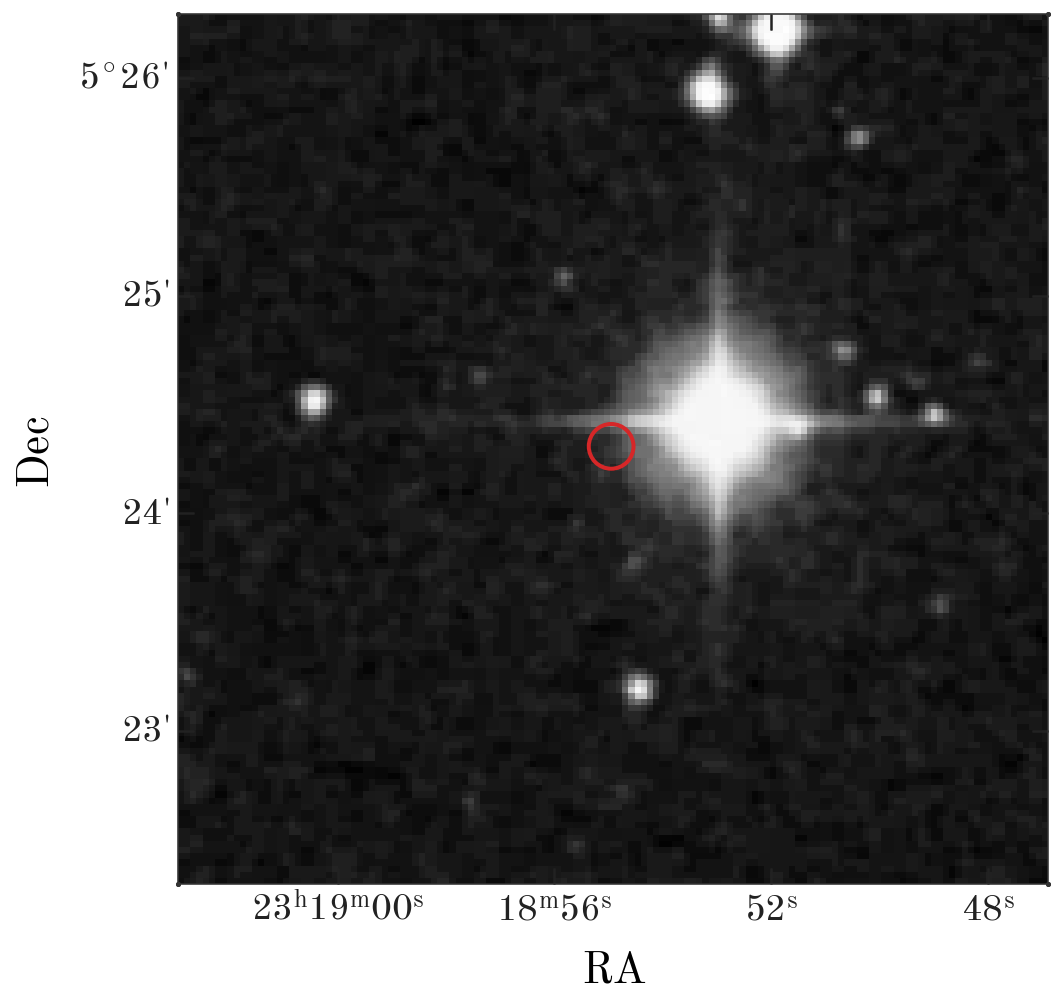

In [25]:
hdu = fits.open(dss_cutout_filename)[0]
wcs = WCS(hdu.header)

fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                       subplot_kw=dict(projection=wcs))
ax.imshow(hdu.data, origin='lower', cmap='Greys_r')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_autoscale_on(False)

ax.scatter(hd219829_coord.ra.degree,
           hd219829_coord.dec.degree,
           s=500,
           transform=ax.get_transform('world'),
           facecolor='none', linewidth=2, color='tab:red')

The brighest star (as observed by DSS) in this image is our target, and the red circle is where *Gaia* observed this star. As we excpected, it has moved quite a bit since the 1950's! We can account for this motion and predict the position of the star at around the time the DSS plate was observed. Let's assume that this plate was observed in 1950 exactly (this is not strictly correct, but should get us close enough).

To account for the proper motion of the source and evolve the position to a new time, we can use the `SkyCoord.apply_space_motion()` method ([docs](http://docs.astropy.org/en/latest/api/astropy.coordinates.SkyCoord.html#astropy.coordinates.SkyCoord.apply_space_motion)). Because we defined the `obstime` when we defined the coordinate object for HD 219829, for example:

In [26]:
hd219829_coord.obstime

<Time object: scale='tt' format='jyear' value=2015.5>

We can now use `apply_space_motion()` by passing in a new time, `new_obstime`, to compute the coordinates at:

In [27]:
# this produces some warnings that we can safely ignore
with warnings.catch_warnings(): 
    warnings.simplefilter('ignore', UserWarning)
    
    hd219829_coord_1950 = hd219829_coord.apply_space_motion(
        new_obstime=Time('J1950'))

Let's now plot our predicted position for this source as it would appear in 1950 based on the *Gaia* position and proper motion:

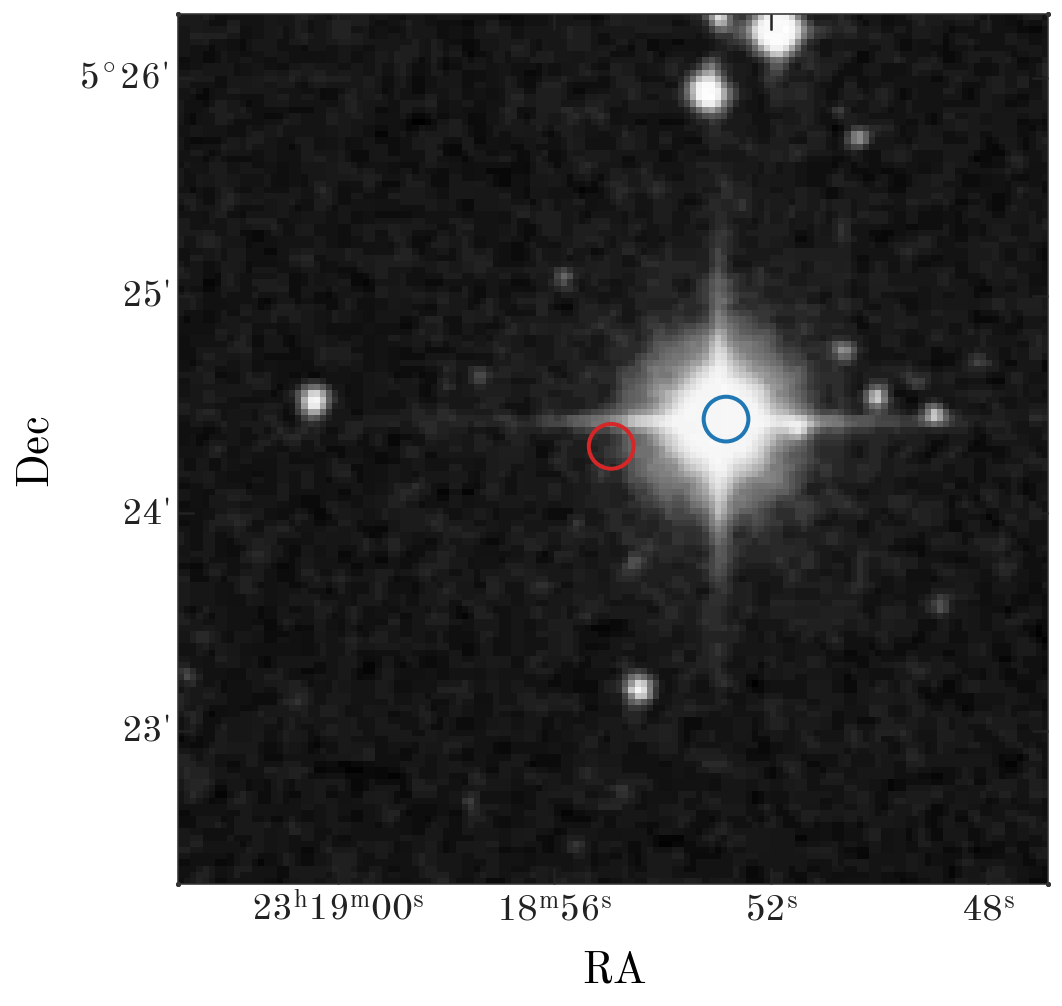

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                       subplot_kw=dict(projection=wcs))
ax.imshow(hdu.data, origin='lower', cmap='Greys_r')
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
ax.set_autoscale_on(False)

ax.scatter(hd219829_coord.ra.degree,
           hd219829_coord.dec.degree,
           s=500,
           transform=ax.get_transform('world'),
           facecolor='none', linewidth=2, color='tab:red')

# Plot the predicted (past) position:
ax.scatter(hd219829_coord_1950.ra.degree,
           hd219829_coord_1950.dec.degree,
           s=500,
           transform=ax.get_transform('world'),
           facecolor='none', linewidth=2, color='tab:blue')

The red circle is the same as in the previous image and shows the position of the source in the *Gaia* catalog (in 2015.5). The blue circle shows our prediction for the position of the source in 1950 - this looks much closer to where the star is in the DSS image!

### Exercises

TODO: old exercise below

The *Gaia* data table we downloaded for sources around NGC 188 also contains proper motion information. Do any of the sources in the field around NGC 188 have large enough proper motions that we might detect a difference between the DSS position of a star and the *Gaia* position? How many stars have an apparent change in position > 5 arcsec over 60 years?

In [ ]:
ngc188_pm = np.sqrt(table['pmra']**2 + table['pmdec']**2)
((ngc188_pm * 60*u.year) > 5*u.arcsec).sum()

Download a DSS image for the region around the fastest-moving star in the NGC 188 field. By accounting for the proper motion, can you predict where the star is in the DSS image using only the *Gaia* position and proper motion?

In this tutorial, we have introduced how to store and transform velocity data along with positional data in `astropy.coordinates`. We also demonstrated how to use the velocity of a source to predict its position at an earlier or later time. 